In [ ]:
pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

In [ ]:
import torch
import gc
import multiprocessing as mp
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
df_1 = pd.read_csv('/content/drive/MyDrive/gr_1.csv')
df_1

,Unnamed: 0,value/0/#text,value/0/@_name,value/1/#text,value/1/@_name,value/2/#text,value/2/@_name,value/3/#text,value/3/@_name,value/4/#text,value/4/@_name,value/5/#text,value/5/@_name
0,5,25431,id,34533,id_1,34534,id_2,Вертолет с 11 иностранцами на борту упал в Пак...,text_1,В Пакистане упал вертолет с 11 иностранцами,text_2,1,class
1,6,25432,id,34535,id_1,34536,id_2,Самолет вернулся в аэропорт Новосибирска из-за...,text_1,Самолет вернулся в новосибирский аэропорт из-з...,text_2,1,class
2,9,25443,id,34556,id_1,34557,id_2,Суд оправдал Васильеву в хищении акций на два ...,text_1,Суд оправдал Васильеву в хищении акций на 2 мл...,text_2,1,class
3,10,25447,id,34560,id_1,34561,id_2,Пушков: у Обамы не хватило духа лично поздрави...,text_1,Пушков: Обама не нашел в себе духа лично поздр...,text_2,1,class
4,11,25448,id,34562,id_1,34563,id_2,МЧС РФ: тела погибших российских дипломатов до...,text_1,Тела погибших в Непале российских дипломатов д...,text_2,1,class
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1913,28473,id,37587,id_1,37588,id_2,Источник в МИД: Россия ввела визовые ограничен...,text_1,Визовые ограничения со стороны России стали от...,text_2,1,class
370,1915,28479,id,37584,id_1,37593,id_2,Саркози раскритиковал Олланда за отказ от посе...,text_1,Саркози осудил отказ Олланда приехать в Москву...,text_2,1,class
371,1916,28481,id,37594,id_1,37595,id_2,Почти 30 человек стали жертвами взрыва в мечет...,text_1,Не менее 26 человек погибли в результате терак...,text_2,1,class
372,1918,28483,id,37596,id_1,37597,id_2,Пушков: Саакашвили в Грузии мог бы возглавить ...,text_1,Пушков заявил о способности Саакашвили возглав...,text_2,1,class


In [ ]:
sentences1 = df_1['value/3/#text'].tolist()
sentences2 = df_1['value/4/#text'].tolist()

In [ ]:
cos = torch.nn.CosineSimilarity(dim=1)

In [ ]:
%%time
DF_FILE = '/content/drive/MyDrive/gr_1.csv'
# размер одного обрабатываемого кусочка датафрейма
CHUNKSIZE = 20

def process_frame(df_1):
  # функция принимает на вход датафрейм и возвращает косинусные подобия для каждого ряда
  similarities_1 = []
  for n, row in tqdm(df_1.iterrows()):
    s = row['value/3/#text']
    t = row['value/4/#text']
    tokens_s = tokenizer([s], return_tensors="pt", padding=True)
    tokens_t = tokenizer([t], return_tensors="pt", padding=True)
    out_s = model(**tokens_s)
    out_t = model(**tokens_t)
    vec_s = torch.mean(out_s.last_hidden_state, dim=1)
    vec_t = torch.mean(out_t.last_hidden_state, dim=1)
    cos_sim = cos(vec_s, vec_t)
    # item() превращает тензор во float
    similarities_1.append(cos_sim.item())
    # на всякий случай собираем ненужное при помощи garbage collector
    gc.collect()
  return similarities_1

# читаем файл по кусочкам заданного размера
reader = pd.read_csv(DF_FILE, chunksize=CHUNKSIZE)
# количество процессов, которые могут идти одновременно
pool = mp.Pool(4)

funclist_1 = []
for df_1_new in reader:
  # открываем и обрабатываем каждый кусочек
  df_1.columns = ['Unnamed:', 'value/0/#text', 'value/0/@_name', 'value/1/#text', 'value/1/@_name', 'value/2/#text', 'value/2/@_name', 'value/3/#text', 'value/3/@_name', 'value/4/#text', 'value/4/@_name', 'value/5/#text', 'value/5/@_name']
  f = pool.apply_async(process_frame, [df_1_new])
  funclist_1.append(f)

result_1 = []
for f in funclist_1:
  # таймаут можно увеличить, если возникает ошибка
  sims = f.get(timeout=500)
  result_1.extend(sims)

In [ ]:
result_1[:374]

In [ ]:
import numpy as np
np.mean(np.array(result_1))

0.943957149663711

In [ ]:
np.std(np.array(result_1))

0.05015615560909323

In [ ]:
df_2 = pd.read_csv('/content/drive/MyDrive/gr_0.csv')
df_2

,Unnamed: 0,value/0/#text,value/0/@_name,value/1/#text,value/1/@_name,value/2/#text,value/2/@_name,value/3/#text,value/3/@_name,value/4/#text,value/4/@_name,value/5/#text,value/5/@_name
0,7,25438,id,34547,id_1,34546,id_2,Васильева признана виновной в мошенничестве и ...,text_1,Васильева признана виновной в хищениях и отмыв...,text_2,0,class
1,13,25456,id,34567,id_1,34568,id_2,Троих подростков-убийц поймали в Подмосковье,text_1,В Подмосковье трое подростков признались в сер...,text_2,0,class
2,20,25477,id,34590,id_1,34589,id_2,Лидер либдемов Ник Клегг подал в отставку посл...,text_1,Лидер британских лейбористов подал в отставку ...,text_2,0,class
3,26,25491,id,34605,id_1,34603,id_2,Консерваторы увеличили отрыв от лейбористов на...,text_1,Консерваторы победили на выборах в Британии,text_2,0,class
4,27,25492,id,34606,id_1,34607,id_2,Лавров о возможной встрече с Керри: готов встр...,text_1,Лавров заявил о готовности встретиться с Керри...,text_2,0,class
...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,1903,28455,id,37516,id_1,37566,id_2,В аэропортах Москвы из-за грозы задержаны и от...,text_1,Более 150 авиарейсов отменили в московских аэр...,text_2,0,class
774,1904,28456,id,37567,id_1,37568,id_2,Объекты инфраструктуры для ВС России в Арктике...,text_1,Все объекты военной инфраструктуры в Арктике с...,text_2,0,class
775,1910,28466,id,37574,id_1,37575,id_2,Пушилин назвал насмешкой над Украиной назначен...,text_1,Медведев назвал назначение Саакашвили «продолж...,text_2,0,class
776,1914,28475,id,37591,id_1,37590,id_2,Россия планирует создать войска быстрого реаги...,text_1,В России появятся войска быстрого реагирования...,text_2,0,class


In [ ]:
sentences3 = df_2['value/3/#text'].tolist()
sentences4 = df_2['value/4/#text'].tolist()

In [ ]:
cos = torch.nn.CosineSimilarity(dim=1)

In [ ]:
%%time
DF_FILE = '/content/drive/MyDrive/gr_0.csv'
# размер одного обрабатываемого кусочка датафрейма
CHUNKSIZE = 20

def process_frame(df_2):
  # функция принимает на вход датафрейм и возвращает косинусные подобия для каждого ряда
  similarities_2 = []
  for n, row in tqdm(df_2.iterrows()):
    s = row['value/3/#text']
    t = row['value/4/#text']
    tokens_s = tokenizer([s], return_tensors="pt", padding=True)
    tokens_t = tokenizer([t], return_tensors="pt", padding=True)
    out_s = model(**tokens_s)
    out_t = model(**tokens_t)
    vec_s = torch.mean(out_s.last_hidden_state, dim=1)
    vec_t = torch.mean(out_t.last_hidden_state, dim=1)
    cos_sim = cos(vec_s, vec_t)
    # item() превращает тензор во float
    similarities_2.append(cos_sim.item())
    # на всякий случай собираем ненужное при помощи garbage collector
    gc.collect()
  return similarities_2

# читаем файл по кусочкам заданного размера
reader = pd.read_csv(DF_FILE, chunksize=CHUNKSIZE)
# количество процессов, которые могут идти одновременно
pool = mp.Pool(4)

funclist_2 = []
for df_2_new in reader:
  # открываем и обрабатываем каждый кусочек
  df_2.columns = ['Unnamed:', 'value/0/#text', 'value/0/@_name', 'value/1/#text', 'value/1/@_name', 'value/2/#text', 'value/2/@_name', 'value/3/#text', 'value/3/@_name', 'value/4/#text', 'value/4/@_name', 'value/5/#text', 'value/5/@_name']
  f = pool.apply_async(process_frame, [df_2_new])
  funclist_2.append(f)

result_2 = []
for f in funclist_2:
  # таймаут можно увеличить, если возникает ошибка
  sims = f.get(timeout=500)
  result_2.extend(sims)

In [ ]:
result_2[:778]

In [ ]:
np.mean(np.array(result_2))

0.8931577150496848

In [ ]:
np.std(np.array(result_2))

0.07310551854126952

In [ ]:
df_3 = pd.read_csv('/content/drive/MyDrive/gr_-1.csv')
df_3

,Unnamed: 0,value/0/#text,value/0/@_name,value/1/#text,value/1/@_name,value/2/#text,value/2/@_name,value/3/#text,value/3/@_name,value/4/#text,value/4/@_name,value/5/#text,value/5/@_name
0,0,25349,id,34420,id_1,34421,id_2,Цены на нефть восстанавливаются,text_1,Парламент Словакии поблагодарил народы бывшего...,text_2,-1,class
1,1,25360,id,34438,id_1,34439,id_2,"""Гоголь-центр"" покажет видеозапись скандальног...",text_1,Кехман запретил «Гоголь-центру» показывать вид...,text_2,-1,class
2,2,25382,id,34475,id_1,34476,id_2,Агент: РФС вновь задерживает зарплату Фабио Ка...,text_1,СМИ: Агент Фабио Капелло грозится подать в суд...,text_2,-1,class
3,3,25423,id,34494,id_1,34519,id_2,День Победы в Москве обещает выдаться облачным,text_1,Любляна отпразднует День Победы вместе с Москвой,text_2,-1,class
4,4,25430,id,34531,id_1,34532,id_2,Посол РФ в США: Россия будет бороться с попытк...,text_1,Правительство запланировало заработать на лоте...,text_2,-1,class
...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,1909,28464,id,37477,id_1,37572,id_2,Саакашвили может стать губернатором Одесской о...,text_1,Медведев назвал назвачение Саакашвили одесским...,text_2,-1,class
768,1917,28482,id,37501,id_1,37595,id_2,Шестнадцать человек погибли в результате авари...,text_1,Не менее 26 человек погибли в результате терак...,text_2,-1,class
769,1921,28499,id,37606,id_1,37618,id_2,Полицейские в США застрелили афроамериканца в ...,text_1,Полицейский в США спас мужчину от наводнения и...,text_2,-1,class
770,1922,28510,id,37604,id_1,37636,id_2,"Полицейский в США спас мужчину от наводнения, ...",text_1,Washington Post: В 2015 году полицейские США з...,text_2,-1,class


In [ ]:
sentences5 = df_3['value/3/#text'].tolist()
sentences6 = df_3['value/4/#text'].tolist()

In [ ]:
cos = torch.nn.CosineSimilarity(dim=1)

In [ ]:
%%time
DF_FILE = '/content/drive/MyDrive/gr_-1.csv'
# размер одного обрабатываемого кусочка датафрейма
CHUNKSIZE = 20

def process_frame(df_3):
  # функция принимает на вход датафрейм и возвращает косинусные подобия для каждого ряда
  similarities_3 = []
  for n, row in tqdm(df_3.iterrows()):
    s = row['value/3/#text']
    t = row['value/4/#text']
    tokens_s = tokenizer([s], return_tensors="pt", padding=True)
    tokens_t = tokenizer([t], return_tensors="pt", padding=True)
    out_s = model(**tokens_s)
    out_t = model(**tokens_t)
    vec_s = torch.mean(out_s.last_hidden_state, dim=1)
    vec_t = torch.mean(out_t.last_hidden_state, dim=1)
    cos_sim = cos(vec_s, vec_t)
    # item() превращает тензор во float
    similarities_3.append(cos_sim.item())
    # на всякий случай собираем ненужное при помощи garbage collector
    gc.collect()
  return similarities_3

# читаем файл по кусочкам заданного размера
reader = pd.read_csv(DF_FILE, chunksize=CHUNKSIZE)
# количество процессов, которые могут идти одновременно
pool = mp.Pool(4)

funclist_3 = []
for df_3_new in reader:
  # открываем и обрабатываем каждый кусочек
  df_3.columns = ['Unnamed:', 'value/0/#text', 'value/0/@_name', 'value/1/#text', 'value/1/@_name', 'value/2/#text', 'value/2/@_name', 'value/3/#text', 'value/3/@_name', 'value/4/#text', 'value/4/@_name', 'value/5/#text', 'value/5/@_name']
  f = pool.apply_async(process_frame, [df_3_new])
  funclist_3.append(f)

result_3 = []
for f in funclist_3:
  # таймаут можно увеличить, если возникает ошибка
  sims = f.get(timeout=500)
  result_3.extend(sims)

In [ ]:
result_3[:772]

In [ ]:
np.mean(np.array(result_3))

0.7661156684855105

In [ ]:
np.std(np.array(result_3))

0.13396752509419885

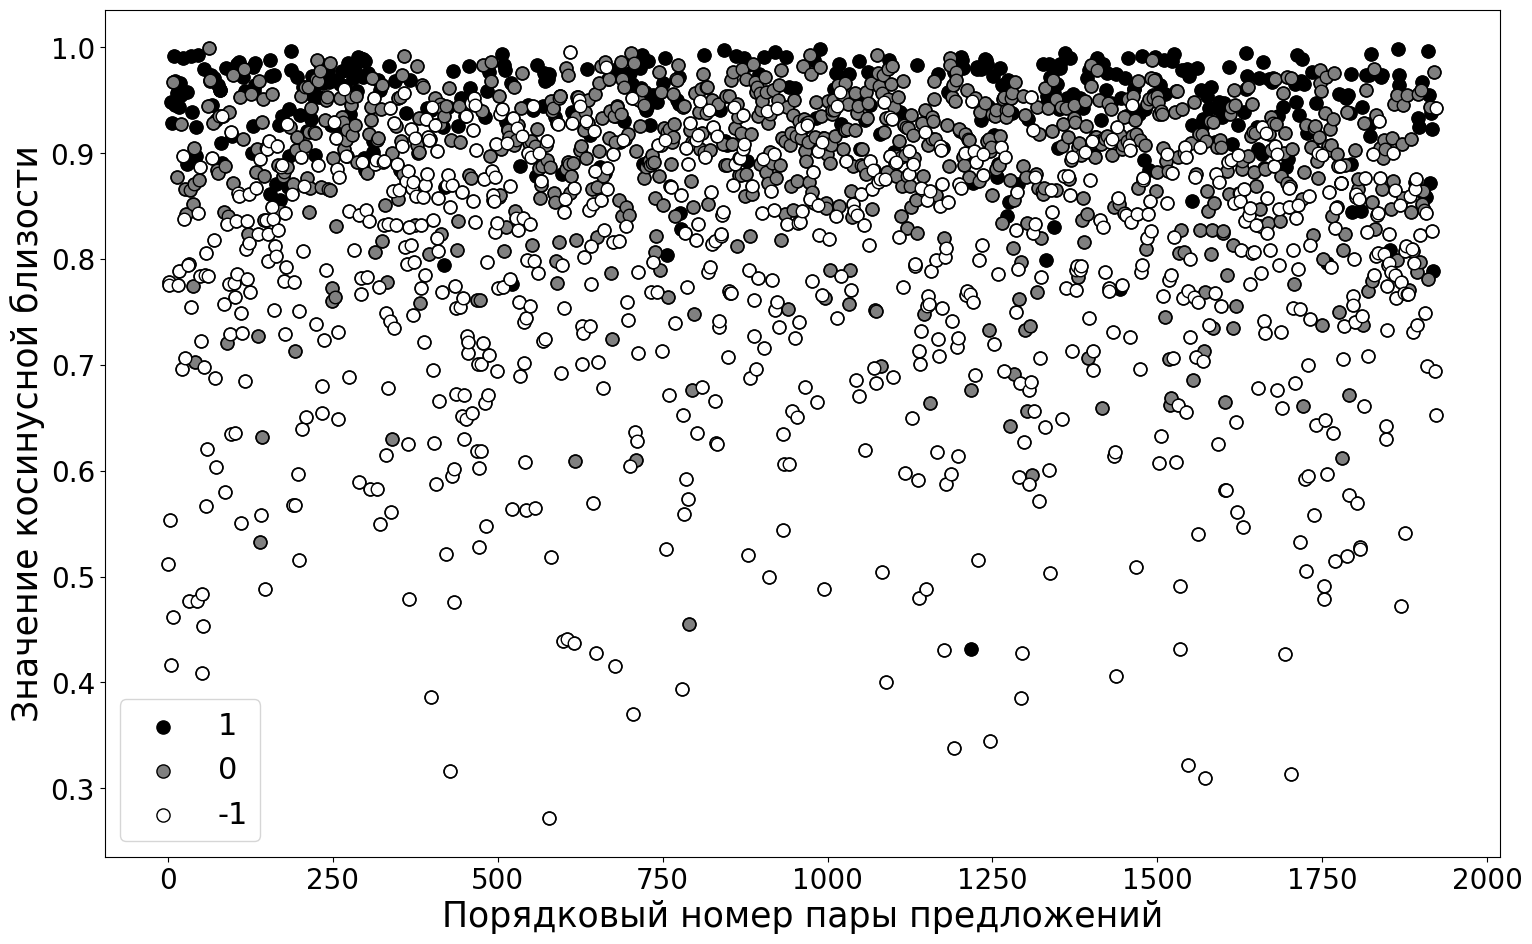

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(18, 11))

x1 = df_1['Unnamed:'].tolist()
y1 = result_1
plt.plot(x1, y1, marker='o', color='black', markersize=9, linewidth=0, markeredgecolor='black')

x2 = df_2['Unnamed:'].tolist()
y2 = result_2
plt.plot(x2, y2, marker='o', color='grey', markersize=9, linewidth=0, markeredgecolor='black')

x3 = df_3['Unnamed:'].tolist()
y3 = result_3
plt.plot(x3, y3, marker='o', color='white', markersize=9, linewidth=0, markeredgecolor='black')

ax.scatter(x1, y1, label = '1', color = 'black', edgecolor='black', s=90)
ax.scatter(x2, y2, label = '0', color = 'grey', edgecolor='black', s=90)
ax.scatter(x3, y3, label = '-1', color = 'white', edgecolor='black', s=90)
ax.legend(fontsize=22)

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

plt.xlabel("Порядковый номер пары предложений", fontsize = 25)
plt.ylabel("Значение косинусной близости", fontsize = 25)

plt.show()